### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
#sc.stop()

findspark.init()

from pyspark import SparkContext
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])
#sc.stop()
from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBBSS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df=sqlContext.read.parquet(filename)
print df.count()
df.show(30)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12112
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   2038.2| 33.8833|-108.5333|       TMAX|USC00290512|     0|[40 52 00 53 00 5...|1910.0|SSSSBBSS|
|   2038.2| 33.8833|-108.5333|       TMAX|USC00290512|    41|[00 7E 40 4C 80 5...|1911.0|SSSSBBSS|
|   2038.2| 33.8833|-108.5333|       TMAX|USC00290512|     0|[80 C9 80 4D E0 5...|1912.0|SSSSBBSS|
|   2038.2| 33.8833|-108.5333|       TMAX|USC00290512|    20|[A0 56 90 55 B0 5...|1913.0|SSSSBBSS|
|   2038.2| 33.8833|-108.5333|       TMAX|USC00290512|    17|[50 57 40 56 00 5...|1914.0|SSSSBBSS|
|   2038.2| 33.8833|-108.5333|       TMAX|USC00290512|    17|[80 54 00 58 

### Select data for a particular station and measurement type

In [2]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USW00093139')
Query1="SELECT DISTINCT station, year, vector FROM weather\n\tWHERE measurement='SNWD'"

Query2 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'SNWD') a WHERE rn = 1"

print Query
df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(Query2)

print df1.count(),'rows'
df1.show(2)
df2.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
T=np.vstack(rows.collect())
T=T/10.  # scaling to make the temperature be in centingrates
print T

shape(T)



SELECT * FROM weather
	WHERE measurement='SNWD' and station='USW00093139'
60 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1478.3| 34.2325|-111.3447|       SNWD|USW00093139|     0|[00 00 60 52 60 5...|1949.0|SSSSBBSS|
|   1478.3| 34.2325|-111.3447|       SNWD|USW00093139|     0|[00 00 00 00 00 0...|1950.0|SSSSBBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

+-----------+------+--------------------+---+
|    station|  year|              vector| rn|
+-----------+------+--------------------+---+
|USC00023448|1916.0|[00 7E 00 00 00 0...|  1|
|USC00023501|2010.0|[00 00 00 00 00 0...|  1|
|USC00294101|1907.0|[00 00 00 00 00 0...|  1|
|USC00297191|1987.0|[00

(60, 365)

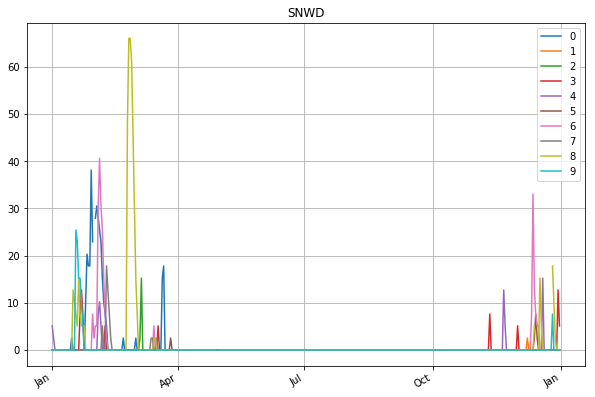

In [3]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[30:40,:].transpose(),fig,ax,title='SNWD')

#title('A sample of graphs');

In [79]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USW00093139')
Query1="SELECT DISTINCT station, year, vector FROM weather\n\tWHERE measurement='TMIN'"

Query2 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'SNWD') a WHERE rn = 1"
Query3 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'TMIN') a WHERE rn = 1"

print Query
df1 = sqlContext.sql(Query1)
df2 = sqlContext.sql(Query2)
df3 = sqlContext.sql(Query3)

print df1.count(),'rows'
df1.show(2)
df2.show(10)
rowsCold = df3.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
rows=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
temp = rows.flatMap(lambda r: r).map(lambda r: (r,1)).reduceByKey(lambda x,y: x+y).map(lambda (k,v):(v,k)).sortByKey(False)
print(temp.take(10))
T=np.vstack(rows.collect())
T=T/10.  # scaling to make the temperature be in centingrates
print T

shape(T)

SELECT * FROM weather
	WHERE measurement='TMAX' and station='USW00093139'
1907 rows
+-----------+------+--------------------+
|    station|  year|              vector|
+-----------+------+--------------------+
|USC00027876|1954.0|[20 D0 00 C6 00 4...|
|USC00027876|1975.0|[00 C6 40 CC 30 D...|
+-----------+------+--------------------+
only showing top 2 rows

+-----------+------+--------------------+---+
|    station|  year|              vector| rn|
+-----------+------+--------------------+---+
|USC00023448|1916.0|[00 7E 00 00 00 0...|  1|
|USC00023501|2010.0|[00 00 00 00 00 0...|  1|
|USC00294101|1907.0|[00 00 00 00 00 0...|  1|
|USC00297191|1987.0|[00 00 00 00 00 0...|  1|
|USC00020632|1940.0|[00 00 00 00 00 0...|  1|
|USC00020307|1966.0|[00 00 00 00 00 0...|  1|
|USC00029622|1904.0|[00 00 00 00 00 0...|  1|
|USC00023926|1968.0|[F6 64 C3 64 C3 6...|  1|
|USC00020288|1988.0|[00 00 00 00 00 0...|  1|
|USC00026653|1965.0|[00 00 00 00 00 0...|  1|
+-----------+------+--------------------+

(57, 365)

In [80]:
print(temp.count())

857


In [81]:
tmp=temp.collect()

In [82]:
list1= [ x[0] for x in tmp ]
list2= [ x[1] for x in tmp ]

In [83]:
np.nanmax(list2)-np.nanmin(list2)

1270.0

[145, 110, 95, 81, 74, 59, 30]
[51.0, 25.0, 76.0, 102.0, 152.0, 127.0, 178.0]


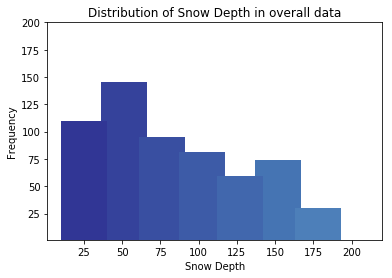

In [89]:
import matplotlib.pyplot as plt
#print tmp.shape, type(tmp)
# This is  the colormap I'd like to use.
# This is  the colormap I'd like to use.
cm = plt.cm.get_cmap('RdYlBu_r')
x_span = np.nanmax(list2)-np.nanmin(list2)

cleanedList1 = [] 
cleanedList2 = []
for x,y in zip(list1,list2): 
    if x > 1 and y!='nan' and y<=200 and x<=200:
        cleanedList1.append(x)
        cleanedList2.append(y)


C = [cm(((x-np.nanmin(cleanedList2))/x_span)) for x in cleanedList2]
plt.ylim([1, 200])
plt.xlim([1, 220])

print cleanedList1
print cleanedList2
plt.bar(np.array(cleanedList2),np.array(cleanedList1),color=C,width=30.0);
plt.xlabel('Snow Depth')
plt.ylabel('Frequency')
plt.title('Distribution of Snow Depth in overall data')
# for i in range(len(list1)):
#     plt.hlines(list1[i],0,list2[i]) 
plt.show()

In [4]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query1 = "SELECT * FROM (SELECT  station, year, vector, latitude, longitude, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'TMAX') a WHERE rn = 1"
Query2 = "SELECT * FROM (SELECT  station, year, vector, latitude, longitude, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'TMIN') a WHERE rn = 1"
Query3 = "SELECT * FROM (SELECT  station, year, vector, latitude, longitude, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'PRCP' AND STATION IN ('USC00029622', 'USW00053019', 'US1AZMR0218', 'USC00029534', 'USC00026653', 'USC00023500', 'USC00023501', 'USC00023505')) a WHERE rn = 1"




#Query1="SELECT station, year, vector FROM weather\n\tWHERE measurement='TMAX'"
df1 = sqlContext.sql(Query1)
df2 = sqlContext.sql(Query2)
df3 = sqlContext.sql(Query3)

df1.show(2)

tempHot=df1.rdd.map(lambda row: (np.nanmax(unpackArray(row['vector'],np.float16)), (row['station'], row['year'], row['latitude'], row['longitude']))).reduceByKey(lambda x,y: x).sortByKey(False)
tempCold=df2.rdd.map(lambda row: (np.nanmin(unpackArray(row['vector'],np.float16)), (row['station'], row['year'], row['latitude'], row['longitude']))).reduceByKey(lambda x,y: x).sortByKey()



+-----------+------+--------------------+--------+---------+---+
|    station|  year|              vector|latitude|longitude| rn|
+-----------+------+--------------------+--------+---------+---+
|USC00023501|2010.0|[F0 56 50 57 28 5...| 33.3947|-110.7933|  1|
|USC00294101|1945.0|[00 7E 00 7E 00 7...| 33.7167|-108.7833|  1|
+-----------+------+--------------------+--------+---------+---+
only showing top 2 rows



In [11]:
df3.show()
tempNew=df3.rdd.map(lambda row: (np.nanmin(unpackArray(row['vector'],np.float16)), (row['station'], row['year'], row['latitude'], row['longitude'])))


+-----------+------+--------------------+--------+---------+---+
|    station|  year|              vector|latitude|longitude| rn|
+-----------+------+--------------------+--------+---------+---+
|USC00023501|2010.0|[00 00 00 00 00 0...| 33.3947|-110.7933|  1|
|USC00029622|1904.0|[00 00 00 00 00 0...|    34.1|-110.9333|  1|
|USC00026653|1965.0|[20 54 00 00 00 0...| 34.0989|-110.9442|  1|
|USC00023505|1982.0|[00 00 20 58 00 5...| 33.3767|-110.7711|  1|
|USW00053019|2012.0|[00 00 00 00 00 0...| 33.8208|-109.9831|  1|
|US1AZMR0218|2010.0|[00 00 00 00 00 0...| 33.3671|-111.7204|  1|
|USC00029534|1949.0|[00 42 88 5B 00 0...| 33.8167|-110.9167|  1|
|USC00023500|1976.0|[00 49 00 00 00 0...|  33.395|-110.7828|  1|
+-----------+------+--------------------+--------+---------+---+



In [12]:
tempNew.collect()

[(0.0, (u'USC00023501', 2010.0, 33.3947, -110.7933)),
 (0.0, (u'USC00029622', 1904.0, 34.1, -110.9333)),
 (0.0, (u'USC00026653', 1965.0, 34.0989, -110.9442)),
 (0.0, (u'USC00023505', 1982.0, 33.3767, -110.7711)),
 (0.0, (u'USW00053019', 2012.0, 33.8208, -109.9831)),
 (0.0, (u'US1AZMR0218', 2010.0, 33.3671, -111.7204)),
 (0.0, (u'USC00029534', 1949.0, 33.8167, -110.9167)),
 (0.0, (u'USC00023500', 1976.0, 33.395, -110.7828))]

In [23]:
print(tempHot.take(10))
print(tempCold.take(10))

[(428.0, (u'USC00020632', 1941.0, 33.8097, -111.6497)), (422.0, (u'USR0000AROO', 1992.0, 33.655, -111.1333)), (411.0, (u'USR0000AGLO', 1991.0, 33.3503, -110.6519)), (406.0, (u'USC00023501', 2010.0, 33.3947, -110.7933)), (400.0, (u'USR0000APLE', 1998.0, 34.0933, -110.9333)), (394.0, (u'USC00023505', 1982.0, 33.3767, -110.7711)), (389.0, (u'USC00021749', 1928.0, 34.0375, -110.4875)), (383.0, (u'USR0000APAY', 1993.0, 34.2431, -111.3028)), (379.0, (u'USW00053019', 2012.0, 33.8208, -109.9831)), (378.0, (u'USC00297386', 1955.0, 33.7158, -108.7769))]
[(-250.0, (u'USC00028326', 1972.0, 33.9733, -109.5631)), (-244.0, (u'USC00023926', 1968.0, 33.9833, -109.75)), (-239.0, (u'USW00003080', 2010.0, 33.715, -108.7772)), (-233.0, (u'USS0009S01S', 1989.0, 33.9833, -109.5167)), (-228.0, (u'USC00297191', 1987.0, 34.1333, -108.5167)), (-222.0, (u'USC00026320', 1910.0, 34.2333, -111.3333)), (-217.0, (u'USC00290512', 1910.0, 33.8833, -108.5333)), (-206.0, (u'USC00297195', 2005.0, 34.1467, -108.5086)), (-20

In [108]:
colds = tempCold.filter(lambda x: x[0]<= 350).collect()
hots = tempCold.filter(lambda x: x[0]>350).collect()

xCold= [ x[0]-350 for x in colds ]
yCold= [ i for i in range(len(colds)) ]
xHot= [ x[0]-350 for x in hots ]
yHot= [ i+ len(colds) for i in range(len(hots)) ]


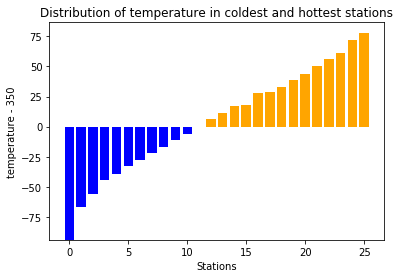

In [113]:
plt.bar(yCold, xCold, color='blue', linewidth=0.3)
plt.bar(yHot, xHot, color='orange', linewidth=0.3)
plt.xlabel('Stations')
plt.ylabel('temperature - 350')
plt.title ('Distribution of temperature in coldest and hottest stations')
# #print(rows.collect())
# #temp = rows.map(lambda r: r).map(lambda r: (r,1)).reduceByKey(lambda x,y: x+y).map(lambda (k,v):(v,k)).sortByKey(False)
# #print(temp.take(10))
# T=np.vstack(rows.collect())
# T=T/10.  # scaling to make the temperature be in centingrates
# print T

# #shape(T)

In [18]:
min_long, max_long, min_lat, max_lat = box = (-111.6447, -108.2167, 33.0767, 34.4639)

In [26]:
tmp = tempHot.filter(lambda x: x[0] > 300).collect()
temp = tempCold.filter(lambda x: x[0] < -100).collect()
for t in temp:
    tmp.append(t)
# tmp = tempHot.collect()
# pdf=tempHot.toDF().toPandas()
# pdf.sort_values(by=['station'],inplace=True)
# pdf.head(2)

In [13]:
tmp = tempNew.collect()

In [14]:
tmp

[(0.0, (u'USC00023501', 2010.0, 33.3947, -110.7933)),
 (0.0, (u'USC00029622', 1904.0, 34.1, -110.9333)),
 (0.0, (u'USC00026653', 1965.0, 34.0989, -110.9442)),
 (0.0, (u'USC00023505', 1982.0, 33.3767, -110.7711)),
 (0.0, (u'USW00053019', 2012.0, 33.8208, -109.9831)),
 (0.0, (u'US1AZMR0218', 2010.0, 33.3671, -111.7204)),
 (0.0, (u'USC00029534', 1949.0, 33.8167, -110.9167)),
 (0.0, (u'USC00023500', 1976.0, 33.395, -110.7828))]

In [21]:
# feature = 'TMAX'
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex


m = []
for t in tmp:
    m.append(t[1][1])
#_min = min(np.array())
_min = np.min(m)
_max = np.max(m)


# _avg='avg(%s)'%feature
# _min=pdf[_avg].min()
# _max=pdf[_avg].max()
# _min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#000080'

In [22]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

In [26]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for row in tmp:
    print row 
    print str(get_color(row[0]))
    _lat=row[1][2]
    _long=row[1][3]
    t = (row[0]-350)
    _count=500 #np.abs(t * 5.5)
    _coef=row[0] 
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(600*np.sqrt(_count)), weight=1,
            color='#F00', opacity=0.6, fill_opacity=0.1,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m 

(0.0, (u'USC00023501', 2010.0, 33.3947, -110.7933))
#000080
(0.0, (u'USC00029622', 1904.0, 34.1, -110.9333))
#000080
(0.0, (u'USC00026653', 1965.0, 34.0989, -110.9442))
#000080
(0.0, (u'USC00023505', 1982.0, 33.3767, -110.7711))
#000080
(0.0, (u'USW00053019', 2012.0, 33.8208, -109.9831))
#000080
(0.0, (u'US1AZMR0218', 2010.0, 33.3671, -111.7204))
#000080
(0.0, (u'USC00029534', 1949.0, 33.8167, -110.9167))
#000080
(0.0, (u'USC00023500', 1976.0, 33.395, -110.7828))
#000080


### Script for plotting yearly plots

[[ 378.]
 [ 400.]
 [ 389.]
 [ 383.]
 [ 400.]
 [ 394.]
 [ 394.]
 [ 400.]
 [ 400.]
 [ 417.]
 [ 378.]
 [ 383.]
 [ 411.]
 [ 389.]
 [ 378.]
 [ 383.]
 [ 378.]
 [ 372.]
 [ 389.]
 [ 383.]
 [ 394.]
 [ 406.]
 [ 400.]
 [ 389.]
 [ 406.]
 [ 394.]
 [ 383.]
 [ 378.]
 [ 378.]
 [ 372.]
 [ 383.]
 [ 389.]
 [ 389.]
 [ 367.]
 [ 378.]
 [ 383.]
 [ 394.]
 [ 378.]
 [ 378.]
 [ 389.]
 [ 400.]
 [ 411.]
 [ 383.]
 [ 361.]
 [ 400.]
 [ 406.]
 [ 417.]
 [ 389.]
 [ 406.]
 [ 406.]
 [ 383.]
 [ 406.]
 [ 378.]
 [ 378.]
 [ 411.]
 [ 361.]
 [ 389.]
 [ 383.]
 [ 400.]
 [ 372.]]


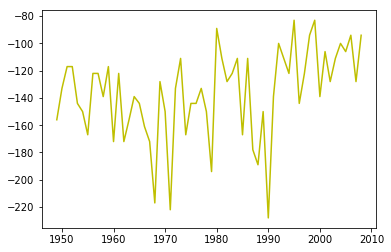

In [58]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USW00093139')
Query1="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USW00093139')
Query2="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USW00093139')
Query3="SELECT year, vector FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMIN','USW00093139')

df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(Query1)
df3 = sqlContext.sql(Query2)
df4 = sqlContext.sql(Query3)

#print df1.count(),'rows'
#df1.show(50)
years = df1.rdd.map(lambda row: row['year']).collect()
s=df1.rdd.map(lambda row:np.nanmean(unpackArray(row['vector'],np.float16))).collect()[:60]
p=df2.rdd.map(lambda row:np.nanmean(unpackArray(row['vector'],np.float16))).collect()[:60]
tmax=df3.rdd.map(lambda row:np.nanmax(unpackArray(row['vector'],np.float16))).collect()[:60]
tmin=df4.rdd.map(lambda row:np.nanmin(unpackArray(row['vector'],np.float16))).collect()[:60]

s=np.vstack(s)
p=np.vstack(p)
tmax=np.vstack(tmax)
tmin=np.vstack(tmin)
# print tmax
import matplotlib.pyplot as plt
# plt.plot(years,s ,'b-')
# plt.plot(years,p ,'r-')
# plt.plot(years,tmax ,'g-')
plt.plot(years,tmin ,'y-')
#plt.axis([0, 6, 0, 20])
plt.show()

In [215]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USW00093139')
Query1="SELECT DISTINCT station, year, vector FROM weather\n\tWHERE measurement='SNWD'"

Query2 = "SELECT * FROM (SELECT  station, year, vector, ROW_NUMBER() OVER(PARTITION BY station ORDER BY year) rn FROM weather WHERE measurement = 'SNWD') a WHERE rn = 1"

print Query
df1 = sqlContext.sql(Query)
df2 = sqlContext.sql(Query2)

print df1.count(),'rows'
df1.show(2)
df2.show(10)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16))
T=np.vstack(rows.collect())
T=T/10.  # scaling to make the temperature be in centingrates
print T

shape(T)



SELECT * FROM weather
	WHERE measurement='TMAX' and station='USW00093139'
63 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1478.3| 34.2325|-111.3447|       TMAX|USW00093139|     3|[40 56 20 50 E0 D...|1949.0|SSSSBBSS|
|   1478.3| 34.2325|-111.3447|       TMAX|USW00093139|     0|[50 57 E0 55 00 5...|1950.0|SSSSBBSS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

+-----------+------+--------------------+---+
|    station|  year|              vector| rn|
+-----------+------+--------------------+---+
|USC00023448|1916.0|[00 7E 00 00 00 0...|  1|
|USC00023501|2010.0|[00 00 00 00 00 0...|  1|
|USC00294101|1907.0|[00 00 00 00 00 0...|  1|
|USC00297191|1987.0|[00

(63, 365)

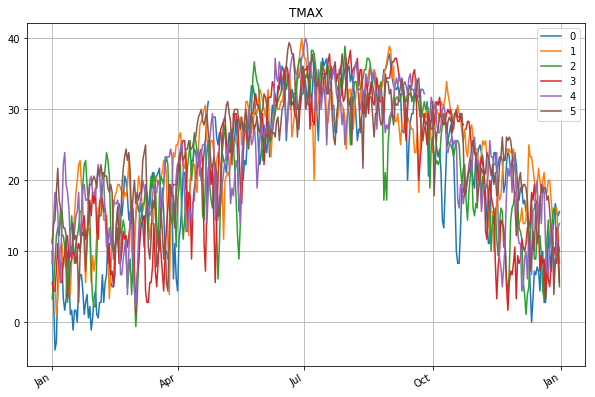

In [216]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:6,:].transpose(),fig,ax,title='TMAX')

#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [9]:
print((STAT['PRCP']['NE']))

[ 2518.  2522.  2524.  2528.  2521.  2527.  2534.  2540.  2535.  2537.
  2531.  2530.  2533.  2533.  2531.  2531.  2518.  2528.  2526.  2532.
  2523.  2521.  2534.  2534.  2538.  2531.  2525.  2534.  2532.  2528.
  2532.  2548.  2543.  2545.  2548.  2547.  2539.  2529.  2528.  2533.
  2531.  2539.  2534.  2529.  2528.  2535.  2536.  2547.  2549.  2536.
  2539.  2533.  2538.  2550.  2543.  2544.  2544.  2543.  2543.  2523.
  2525.  2540.  2536.  2533.  2538.  2538.  2538.  2536.  2541.  2537.
  2536.  2541.  2540.  2544.  2542.  2543.  2542.  2539.  2544.  2545.
  2542.  2543.  2542.  2535.  2534.  2528.  2529.  2534.  2535.  2537.
  2544.  2541.  2544.  2545.  2542.  2543.  2546.  2546.  2552.  2547.
  2550.  2548.  2550.  2551.  2546.  2546.  2547.  2551.  2547.  2546.
  2549.  2549.  2550.  2549.  2553.  2549.  2553.  2553.  2550.  2544.
  2544.  2544.  2545.  2541.  2546.  2546.  2548.  2542.  2549.  2547.
  2546.  2543.  2540.  2543.  2539.  2541.  2549.  2544.  2543.  2545.
  2547

In [217]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/digvijaykaramchandani/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


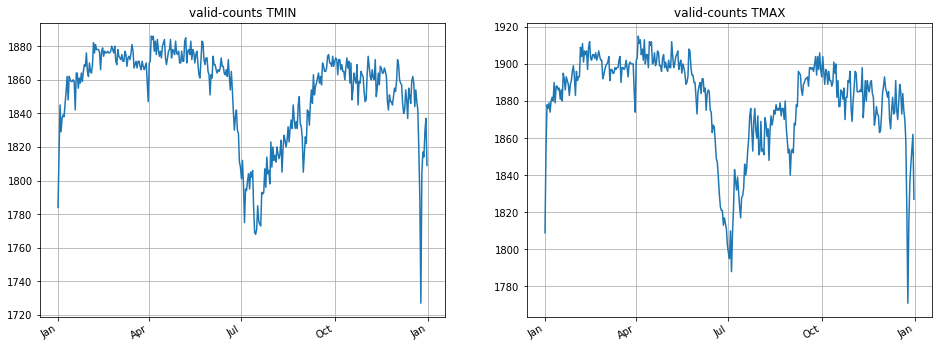

In [218]:
plot_pair(['TMIN','TMAX'],plot_valid)

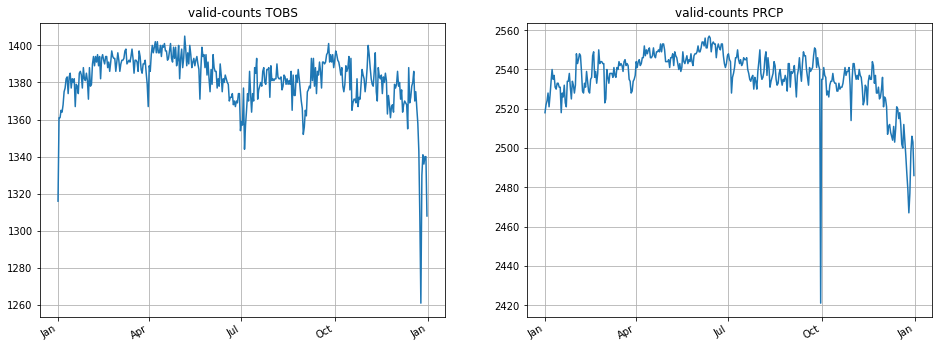

In [219]:
plot_pair(['TOBS','PRCP'],plot_valid)

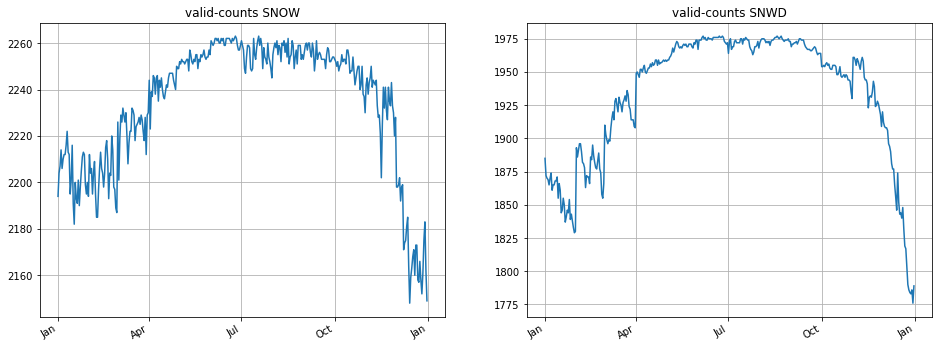

In [220]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [221]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

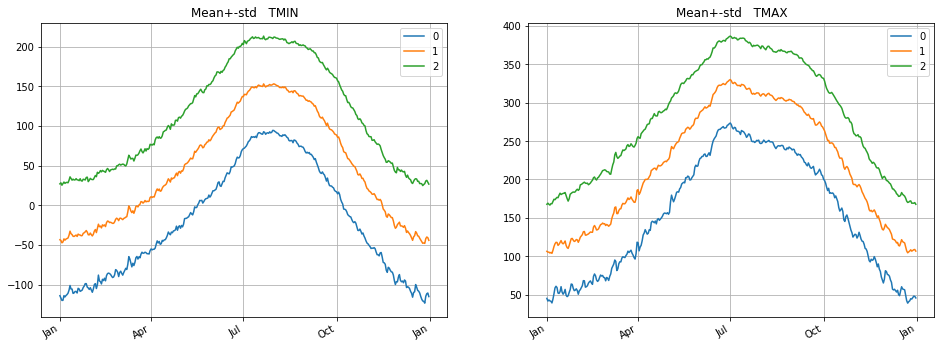

In [222]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

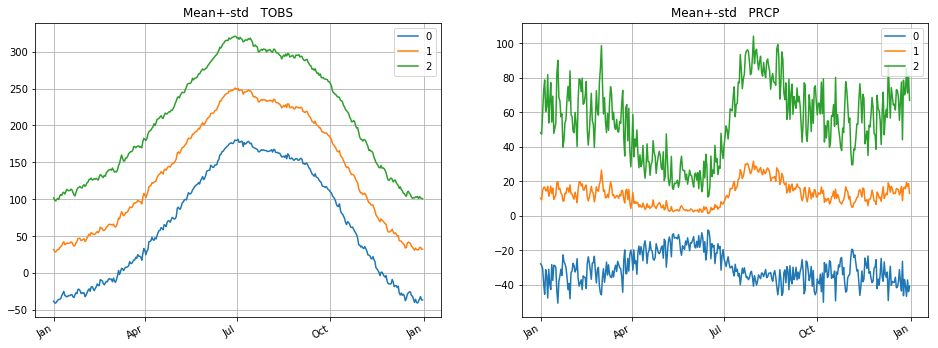

In [223]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

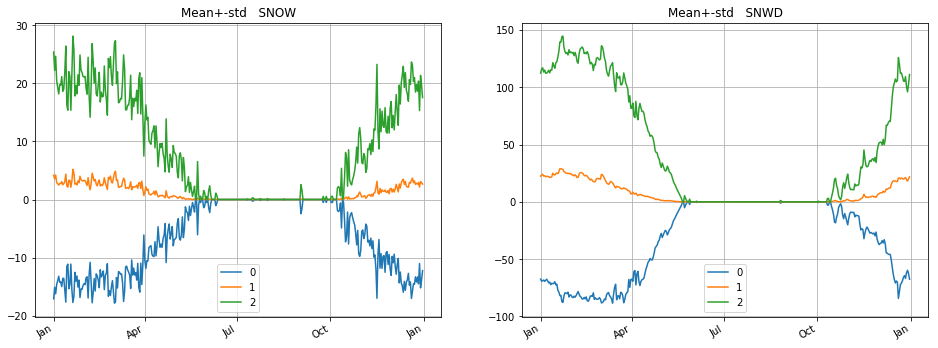

In [224]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [225]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

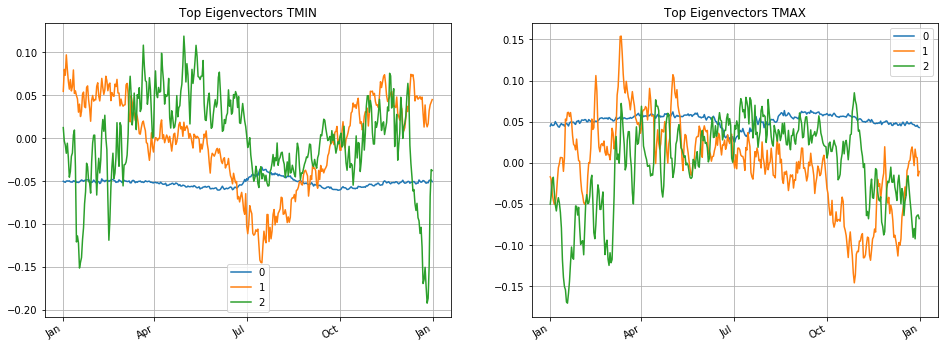

In [226]:
plot_pair(['TMIN','TMAX'],plot_eigen)

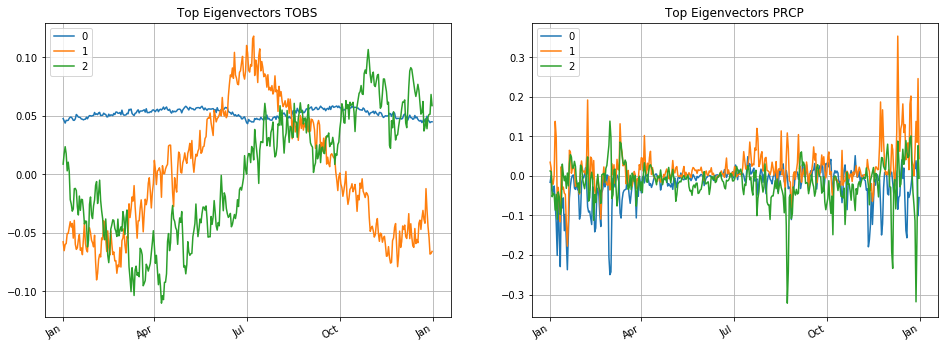

In [227]:
plot_pair(['TOBS','PRCP'],plot_eigen)

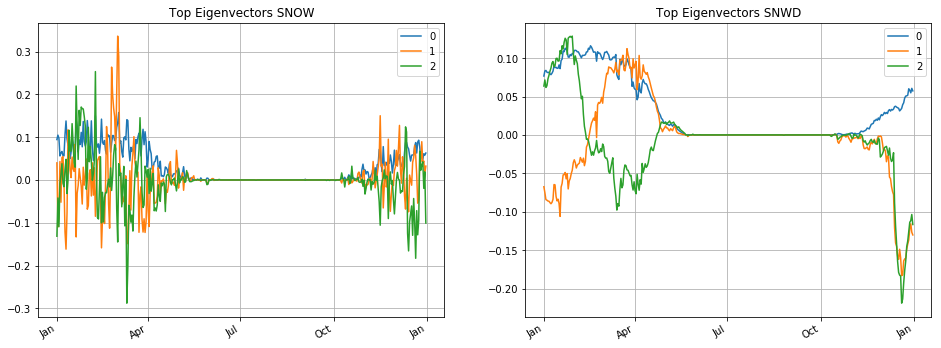

In [228]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [229]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

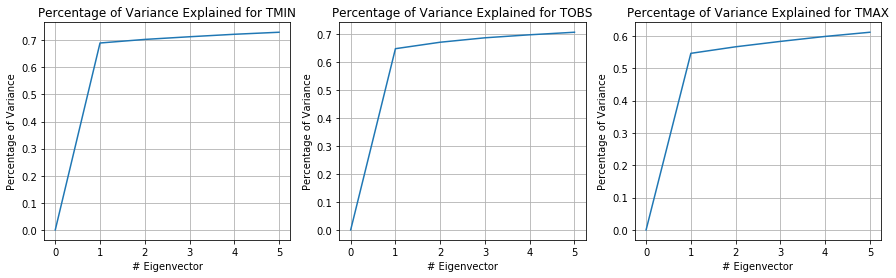

In [230]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

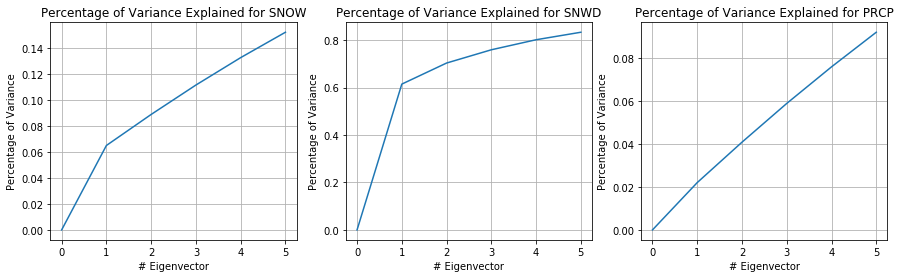

In [231]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [19]:
#sc.stop()